# Refer /Keras /1. preProcess with keras

In [3]:
#https://medium.com/@jatinmandav3/opinion-mining-sometimes-known-as-sentiment-analysis-or-emotion-ai-refers-to-the-use-of-natural-874f369194c0
import os
from tqdm import tqdm
import pandas as pd 
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, GRU,LSTM, Embedding,Flatten, Dropout,CuDNNGRU
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

import pickle
import h5py

from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.callbacks import TensorBoard


PROJ_NAME= "1.0 Glove_pretrained_100dims_20k_LSTM"

MODEL_FILEPATH = f'model_tokenizers_weights_and_json/{PROJ_NAME}_best_model.json'
WEIGHT_FILEPATH = f'model_tokenizers_weights_and_json/{PROJ_NAME}_best_weights.h5'
IMAGE_PATH = f'model_images/{PROJ_NAME}.png'
TOKENIZER_FILEPATH = f'model_tokenizers_weights_and_json/{PROJ_NAME}_tokenizer_instance.pickle'

tensorboard = TensorBoard(log_dir=f'logs/{PROJ_NAME}/')

Using TensorFlow backend.


# making it reproducable

In [4]:
seed = 7

np.random.seed(seed)
from tensorflow import set_random_seed
set_random_seed(seed)

In [5]:
INPUT_TEXT_LENGTH = 294 # from previous notebook
VOCAB_SIZE = 20000      # vocab size needs to be taken care off

In [6]:
df_preprocessed = pd.read_pickle("./pickles/V1_preProcessed.pkl")

# check if 1st 50k are shuffuled

In [7]:
df_preprocessed[49996:50002]

,review,sentiment,word_count
49996,movie nothing like book think writer screenpla...,0.0,55
49997,first watched flatliners amaze necessary featu...,1.0,89
49998,see movie find hard understand many people see...,1.0,87
49999,work class romantic drama director martin ritt...,1.0,92
50000,admit great majority film release say dozen ma...,2.0,73
50001,take low budget inexperienced actor double pro...,2.0,88


# consider only 1st 50 for train and test split it from rest¶

In [8]:
df = pd.DataFrame()
df = df_preprocessed[0:49999]

In [9]:
df['sentiment'].value_counts()

0.0    25000
1.0    24999
Name: sentiment, dtype: int64

# Vectorising usin Keras
- Setting integer value to a string token

In [10]:
%%time 
# create the tokenizer
tokenizer =Tokenizer(num_words=VOCAB_SIZE)
# fit the tokenizer on the documents
tokenizer.fit_on_texts(df["review"])

Wall time: 5.32 s


In [12]:
total_vocab = tokenizer.word_index
#print(total_vocab)

# Setting up vocab size for GLOVE handling

In [13]:
'''
SELECT TOP 20K dict
'''



from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return dict(islice(iterable, n))

vocab_20k = take(VOCAB_SIZE, total_vocab.items())


type(vocab_20k)

dict

In [11]:
len(vocab_20k)

20000

In [1]:
type(vocab_20k)

NameError: name 'vocab_20k' is not defined

# Converting text data to abv to integer values

In [14]:
%%time
seq = tokenizer.texts_to_sequences(df["review"])

Wall time: 4.14 s


# Check for values

In [26]:
 df['review'][155]

'movie ups downs good stuff movie much outweighs bad good movie indeed sometimes dialogue sound light one noticed way set light amateur act good highly original storyline intense atmosphere gore factor high effect do supremely definitely worth watch maybe even must see horror gore fan'

In [24]:
np.array(seq[155])

array([   1, 1516,    8,  392,    1,   24,   17,    8,    1,  706,  414,
        294,  186,  313,    3, 4703,   34,   89,  313, 1865,   36,    8,
        423,  117,  623, 1311,  694,  461, 1567,  168,  139,  125, 7979,
        312,  183,   14,  179,   15,  111,    6,   90,  461,  106])

In [25]:
'''
WE CAN SEE THE DIFFERENCE 10 , BCOZ OTHER VALUES ARE GRATER THEN VOCAB SIZE 20000 ; SO ITS NOT CONSIDERED
'''
print(df['word_count'][155])
print(len(np.array(seq[155])))

45
43


In [16]:
print(" Actual VOCAB_SIZE deined: ",VOCAB_SIZE)
print(" Actual tokens created: ",len(tokenizer.word_index))# IF WE WANT TO CONSIDER EVERY TEXT IN VOCAB PASS THIS

 Actual VOCAB_SIZE deined:  20000
 Actual tokens created:  91671


# Deciding Vocabulary for EMB. matrix
* we can load either 100dims, 300dims * VOCAB_SIZE_new

# Importing pre trained Glove
* https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html 

In [17]:
%%time
Glove_Embedding = {}#dict()
                                                                #100d
f = open('D:/dataset/Embedding/Glove/glove.6B.100d.txt', encoding="utf8")

for line in f:
	values = line.split() # split by lines
	word = values[0]# get 1st word in the line i.e the "word" itself
	coefs = np.asarray(values[1:], dtype='float32') # the preceding vector is the vector itself
	Glove_Embedding[word] = coefs# its a dict of word(key) and vector(value)
f.close()

print('Loaded %s word vectors.' % len(Glove_Embedding))

Loaded 400000 word vectors.
Wall time: 10.6 s


# Pre trained Glove, used as initilzation for our task
* we create 2D array of size (VOCAB_SIZE * 100) 

In [18]:
#so we have to create 2d array
# 50 since we have loaded 100 embd layer Glove matrix
      #Setting up vocab size for GLOVE handling
embedding_matrix = np.zeros((VOCAB_SIZE+1,100))
##words_not_found = []   # words not found in Glove emb. w.r.t our data corpous
import collections
words_not_found = collections.defaultdict(list)

for word, i in vocab_20k.items():
    
    glove_vector_reprsentation = Glove_Embedding.get(word,"NULL")
    if glove_vector_reprsentation != 'NULL':
        embedding_matrix[i] = glove_vector_reprsentation
    else:
        ##words_not_found.append(word)
        words_not_found[word].append(i)     

C:\Users\DBCE\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


In [19]:
#words_not_found  #words not found in Glove embedding; CAN USE WORDCLOUD

In [20]:
print(len(words_not_found))

394


In [20]:
embedding_matrix.shape # Embedding layer matrix

(20001, 100)

# Padding and Truncating Data
* To feed it to N.N, inputs to have the same length
 - Either we ensure that all sequences in the entire data-set have the same length
 - Or Entier batch should be of same length
* Going about choosing ampunt to pad
 - going with longest seq, would be just waste of memory for texr whose length is small
 - going with smalles seq , would be just ignoring other imp values 
 - so we go optimal


In [ ]:
'''
All that the Embedding layer does is to map the integer inputs to the vectors found at the corresponding index in the 
embedding matrix, i.e. the sequence [1, 2] would be converted to [embeddings[1], embeddings[2]]
'''
print(np.array(seq[506]))

[    8  1337    13    25   103  1709    14    92     1  3217 12926   106
    14   199   335     1    52   294  3589  2928   240    14   289   744
   199   335     1    52   294     1   110    32  6941   151   396    76
    25   249   224   148   124    24  2090  2222   152   494   585    81
     2    92    95  1189   879   157   131   195   940    92    59    35
   186   340  4598  1407   322    72   157   346   232   732   229   158
    88  1401    81 11214  2969   373   246    21     2  1419    28   336
     9    91  1385   128    92   184  2969   543   100  9786  3569   903
  6848   577   244    28     9    32  1435    32     1   349  5264  2426
  1293   147  1410  2506  2792   515    92    32 12926   106   148   444
   182  1368    25     2  1934   384   232  1865   909   508  1979 14507
  2608    55  1443   603   232  3031   199   335  7292]


In [ ]:
np.max(np.array(seq[506]))

14507

# Padding and trucating here

In [21]:
imdb_data_pad = sequence.pad_sequences(seq , maxlen=INPUT_TEXT_LENGTH,padding='pre', truncating='pre')

In [22]:
imdb_data_pad.shape
# 2k review
# and 695 fixed I/P shape

(49999, 294)

In [ ]:
#checking
#imdb_data_pad[4]
type(seq)

list

In [ ]:
tokenizer

# Tokenizer Inverse Map

In [31]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [32]:

def tokens_to_string(tokens):
    # Map from tokens back to words.
    words = [inverse_map[token] for token in tokens if token != 0]
    
    # Concatenate all words.
    text = " ".join(words)

    return text

In [ ]:
tokens_to_string(seq[506])

'good lord go say right bat watch minute movie hardcore eraserhead fan watch black white movie little dialogue defense apply simply watch terrible weird black white movie little dialogue movie happen give goth child talent nothing say camera budget let put much offensive imagery screen possible clear start film minute long assume exist shot last second drag minute director love sound voice syndrome refuse cut another shot entire piece footage view moment girl mask start masturbate corpse god open scene film joy know matter time turn tape least minute different corpse pull around twitch rope gang cloak mystery men know time give rarely give movie sit entirety blair witch book shadow albeit happily deserve minute give eraserhead fan let simple mind comparison say film con rent piece amateur trash allow refer tetsuo iron man watchable enjoyable piece incoherent black white weirdness'

In [ ]:
# N.N Model
len(tokenizer.word_index) # This are total word in dict
#it depends if i want to use entier dict or only few occuring word

91671

# Split data to test/ train / dev (disabled for train test split )

In [25]:
X= imdb_data_pad #PADDED VERSION OF DATA
y= df['sentiment'] # LABELS OF DATA

X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.30,stratify=y, random_state=42)                #30%
#  #4%

**Reason for starified split:**
https://stats.stackexchange.com/questions/250273/benefits-of-stratified-vs-random-sampling-for-generating-training-data-in-classi

In [26]:
    #Stratiy on y_train data
    X_train,X_test,y_train,y_test = train_test_split( X_train, y_train, test_size=0.04,stratify=y_train, random_state=42) 

In [27]:
print("Train data:",len(X_train),'  ',len(y_train))
print("Validation data:",len(X_val),'  ',len(y_val))
print("Test data:",len(X_test),'  ',len(y_test))
print(type(y_train))

X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
X_test = np.asarray(X_test)

y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

Train data: 33599    33599
Validation data: 15000    15000
Test data: 1400    1400
<class 'pandas.core.series.Series'>


In [ ]:
y_test[155]

0.0

# CREATING A MODEL
* http://fizzylogic.nl/2017/05/08/monitor-progress-of-your-keras-based-neural-network-using-tensorboard/

In [28]:
%%time
EMBEDDING_DIM = 100 #or 150

model = Sequential()

#model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=INPUT_TEXT_LENGTH))

embedding_layer = Embedding(VOCAB_SIZE+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=INPUT_TEXT_LENGTH, trainable=False)
model.add(embedding_layer)

model.add(LSTM(units=100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# simple early stopping
ec = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(MODEL_FILEPATH, monitor='val_acc', mode='max', verbose=1, save_best_only=True)
#mc = ModelCheckpoint(PROJ_NAME,'_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

'''
embedding_layer = Embedding(VOCAB_SIZE, 50, weights=[embedding_matrix], input_length=INPUT_TEXT_LENGTH, trainable=False)
model.add(embedding_layer)
model.add(Dropout(0.2))
'''
'''model.add(CuDNNGRU(units=8, return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNGRU(units=4))'''


print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 294, 100)          2000100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,080,601
Trainable params: 80,501
Non-trainable params: 2,000,100
_________________________________________________________________
None
Wall time: 3.32 s


# print out model image

In [29]:
from keras.utils import plot_model
import os
#install graph viz locally 1st
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'# install 
plot_model(model, to_file=IMAGE_PATH)

# fitting model with validation data

In [30]:
%%time
history = model.fit(X_train, y_train , epochs=4 , validation_data=(X_val, y_val),verbose=2, batch_size = 64, callbacks=[tensorboard, ec, mc])
# TENSORBOARD
# tensorboard --logdir logs/
# http://localhost:6006/

Train on 33599 samples, validate on 15000 samples
Epoch 1/4
 - 260s - loss: 0.5283 - acc: 0.7367 - val_loss: 0.4080 - val_acc: 0.8171

Epoch 00001: val_acc improved from -inf to 0.81707, saving model to model_tokenizers_weights_and_json/1.0 Glove_pretrained_100dims_20k_LSTM_best_model.json
Epoch 2/4
 - 259s - loss: 0.4180 - acc: 0.8094 - val_loss: 0.3788 - val_acc: 0.8300

Epoch 00002: val_acc improved from 0.81707 to 0.83000, saving model to model_tokenizers_weights_and_json/1.0 Glove_pretrained_100dims_20k_LSTM_best_model.json
Epoch 3/4
 - 259s - loss: 0.3709 - acc: 0.8378 - val_loss: 0.3449 - val_acc: 0.8507

Epoch 00003: val_acc improved from 0.83000 to 0.85067, saving model to model_tokenizers_weights_and_json/1.0 Glove_pretrained_100dims_20k_LSTM_best_model.json
Epoch 4/4
 - 259s - loss: 0.3463 - acc: 0.8498 - val_loss: 0.3160 - val_acc: 0.8650

Epoch 00004: val_acc improved from 0.85067 to 0.86500, saving model to model_tokenizers_weights_and_json/1.0 Glove_pretrained_100dims_20

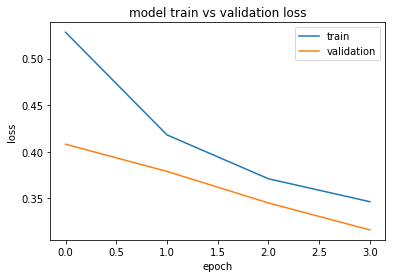

In [31]:
# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Evaluate on test data

In [32]:

# Final evaluation of the model

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 85.79%


# TO DO after training¶

# export tokenizer and weights of model for production
* If model has performed well.

In [34]:
# saving instace so word can be converted to int tokens
with open(TOKENIZER_FILEPATH, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


# saving keras model n weights

In [33]:
# serialize model to JSON
'''model_json = model.to_json()
with open(PROJ_NAME,"_model.json", "w") as json_file: #MODEL_FILEPATH
    json_file.write(model_json)'''
    
# serialize weights to HDF5
model.save_weights(WEIGHT_FILEPATH)
print("Saved model to disk")

Saved model to disk


In [17]:

'''
Neural networks are stochastic, they can produce different results when the same model is fit on the same data.
This is mainly because of the random initial weights and the shuffling of patterns during mini-batch gradient descent. 
This means that any one scoring of a model is unreliable and we should estimate model skill based on an average of multiple runs.
'''
with open(TOKENIZER_FILEPATH, 'rb') as handle:
    prod_instance_tokenizer = pickle.load(handle)


'\nNeural networks are stochastic, they can produce different results when the same model is fit on the same data.\nThis is mainly because of the random initial weights and the shuffling of patterns during mini-batch gradient descent. \nThis means that any one scoring of a model is unreliable and we should estimate model skill based on an average of multiple runs.\n'

In [39]:
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
result = text_to_word_sequence("This movie really sucks! Can I get my money back please")

print(result)
text_to_int= prod_instance.texts_to_sequences(result)
print(text_to_int)

['this', 'movie', 'really', 'sucks', 'can', 'i', 'get', 'my', 'money', 'back', 'please']


NameError: name 'prod_instance' is not defined

# Have to try:
* include pre trained embedding before
* set trainable param**
* other architecture
* hyperparam settings etc..

In [ ]:
'''
'movie ups downs good stuff movie much outweighs bad good movie indeed sometimes dialogue sound light one noticed way 
set light amateur act good highly original 
storyline intense atmosphere gore factor high effect do supremely definitely worth watch maybe even must see horror gore fan'

#refs
# Delete the Keras model with these hyper-parameters from memory.
del model
    
# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()
'''